# Food Delivery Time Prediction With XGBoost Regressor

In [1]:
#Importing necessary library 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import statistics
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("C:\\Users\\rana.putri\\Documents\\Personal Files\\ML Projects\\Food Delivery Time\\Dataset\\train.csv")
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


# Data Preprocessing

In [5]:
df.rename(columns={'Weatherconditions':'Weather_Conditions','Time_taken(min)':'Time_taken_min'},inplace = True)
df.rename(columns=str.lower,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           45593 non-null  object 
 1   delivery_person_id           45593 non-null  object 
 2   delivery_person_age          45593 non-null  object 
 3   delivery_person_ratings      45593 non-null  object 
 4   restaurant_latitude          45593 non-null  float64
 5   restaurant_longitude         45593 non-null  float64
 6   delivery_location_latitude   45593 non-null  float64
 7   delivery_location_longitude  45593 non-null  float64
 8   order_date                   45593 non-null  object 
 9   time_orderd                  45593 non-null  object 
 10  time_order_picked            45593 non-null  object 
 11  weather_conditions           45593 non-null  object 
 12  road_traffic_density         45593 non-null  object 
 13  vehicle_conditio

There are several variables which data type do not match their purpose

In [6]:
## change the data types for the numerical variables
df['delivery_person_age'] = df['delivery_person_age'].astype('float')
df['delivery_person_ratings'] = df['delivery_person_ratings'].astype('float')
df['vehicle_condition'] = df['vehicle_condition'].astype('object')

In [7]:
##To eliminate unnecessary strings from variables
df['weather_conditions'] = df['weather_conditions'].str.split(' ',expand=True)[1]
df['time_taken_min'] = df['time_taken_min'].str.split(' ',expand=True)[1]
##To get the city based on the delivery person id
df['delivery_city'] = df['delivery_person_id'].str.split('RES',expand=True)[0]

##Change the data type for the target variable
df['time_taken_min'] = df['time_taken_min'].astype('float')

In [8]:
## Quantitative Variables Description 
df.describe()

,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,time_taken_min
count,43739.000000,43685.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000
mean,29.567137,4.633780,17.017729,70.231332,17.465186,70.845702,26.294607
std,5.815155,0.334716,8.185109,22.883647,7.335122,21.118812,9.383806
min,15.000000,1.000000,-30.905562,-88.366217,0.010000,0.010000,10.000000
25%,25.000000,4.500000,12.933284,73.170000,12.988453,73.280000,19.000000
50%,30.000000,4.700000,18.546947,75.898497,18.633934,76.002574,26.000000
75%,35.000000,4.900000,22.728163,78.044095,22.785049,78.107044,32.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,54.000000


In [9]:
## Categorical Variables Description 
df.describe(include = 'object')

,id,delivery_person_id,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,delivery_city
count,45593,45593,45593,45593,45593,45593,45593,45593,45593,45593,45593,45593,45593,45593
unique,45593,1320,44,177,193,7,5,4,4,4,5,3,4,22
top,0x4607,PUNERES01DEL01,15-03-2022,NaN,21:30:00,Fog,Low,2,Snack,motorcycle,1,No,Metropolitian,JAP
freq,1,67,1192,1731,496,7654,15477,15034,11533,26435,28159,44469,34093,3443


Based on the description, we could see that: 
1. There are several variables with missing values, e.g: delivery_person_age, delivery_person_ratings
2. The max value for the  delivery_person_ratings is above 5 which will be investigated later
3. There are NaN values in the time_ordered variables


### Handling Missing Values

In [10]:
## To check how many NaN values exist in every columns
for i in df.columns: 
    cts = df[i].apply(lambda x: 1 if (x =='NaN ' or x =='NaN' or pd.isna(x)) else 0).sum()
    print(f'{i} has nan values of : {cts}')

id has nan values of : 0
delivery_person_id has nan values of : 0
delivery_person_age has nan values of : 1854
delivery_person_ratings has nan values of : 1908
restaurant_latitude has nan values of : 0
restaurant_longitude has nan values of : 0
delivery_location_latitude has nan values of : 0
delivery_location_longitude has nan values of : 0
order_date has nan values of : 0
time_orderd has nan values of : 1731
time_order_picked has nan values of : 0
weather_conditions has nan values of : 616
road_traffic_density has nan values of : 601
vehicle_condition has nan values of : 0
type_of_order has nan values of : 0
type_of_vehicle has nan values of : 0
multiple_deliveries has nan values of : 993
festival has nan values of : 228
city has nan values of : 1200
time_taken_min has nan values of : 0
delivery_city has nan values of : 0


In [11]:
## To change the string or NaN characters to np.nan instead for easier handling
for i in df.columns: 
    df[i] = df[i].apply(lambda x: np.nan if (x =='NaN ' or x =='NaN' or pd.isna(x)) else x)

In [12]:
df.isnull().sum().sort_values(ascending = False)

delivery_person_ratings        1908
delivery_person_age            1854
time_orderd                    1731
city                           1200
multiple_deliveries             993
weather_conditions              616
road_traffic_density            601
festival                        228
id                                0
vehicle_condition                 0
time_taken_min                    0
type_of_vehicle                   0
type_of_order                     0
time_order_picked                 0
delivery_person_id                0
order_date                        0
delivery_location_longitude       0
delivery_location_latitude        0
restaurant_longitude              0
restaurant_latitude               0
delivery_city                     0
dtype: int64

There are several ways to handle missing values, including deletion and imputation. Since the number of missing values is quite significant, we will use imputation or replacing the null values with certain value instead to prevent wasting any data points. The null values of each column will be replaced by their measures of central tendency (**mean, median, mode**) based on their distribution

#### Handling Missing Values Numerical Columns

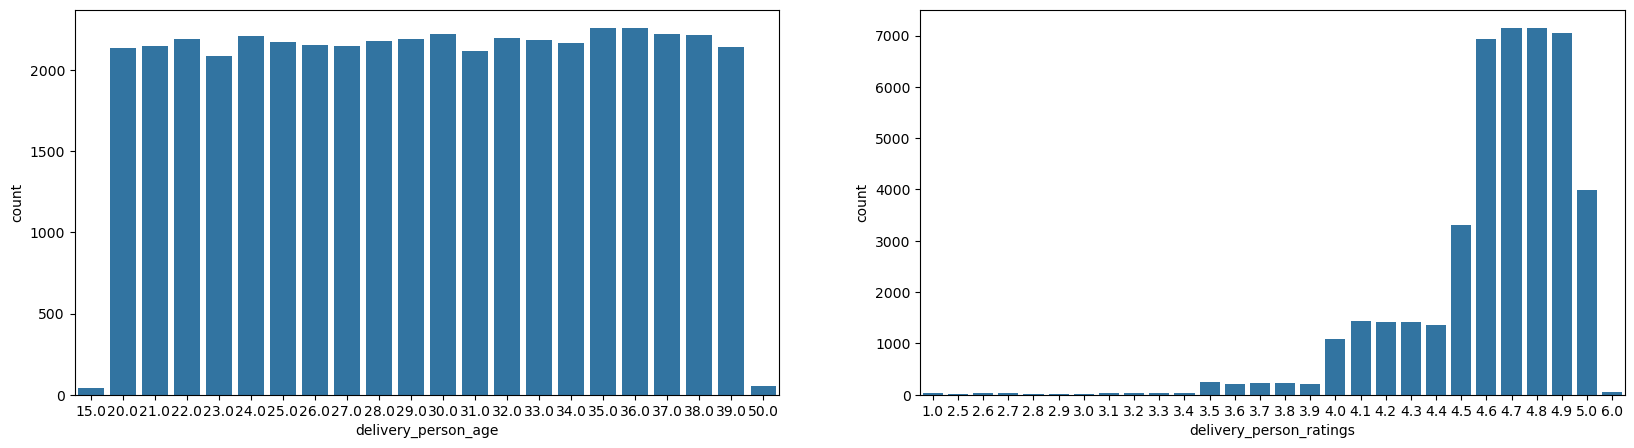

In [13]:
# Create the bins order for the numerical variables
bins1 = df['delivery_person_age'].value_counts().sort_index().index
bins2 = df['delivery_person_ratings'].value_counts().sort_index().index

fig, ax = plt.subplots(1,2,figsize=(20, 5))

sns.countplot(data=df, x='delivery_person_age', order=bins1, ax= ax[0])
sns.countplot(data=df, x='delivery_person_ratings', order=bins2, ax= ax[1])

# Show the plot
plt.show()


The delivery person age reflects uniform distribution, so the null values will be replaced with random values from the column. 
The delivery person ratings has a right skewed distribution, the null values will be replaced with the median. Moreover, there are values with ratings above 5, these values will be converted to the maximum value instead, 5.

In [14]:
#List of non null values from the age column
choice = df['delivery_person_age'][~np.isnan(df['delivery_person_age'])]
df['delivery_person_age'] = df['delivery_person_age'].apply(lambda x : np.random.choice(choice) if pd.isna(x) else x)
#Fill null values with the median and replace 6 with 5
df['delivery_person_ratings'] = df['delivery_person_ratings'].apply(lambda x : df['delivery_person_ratings'].median() if pd.isna(x) else (5 if x > 5 else x))

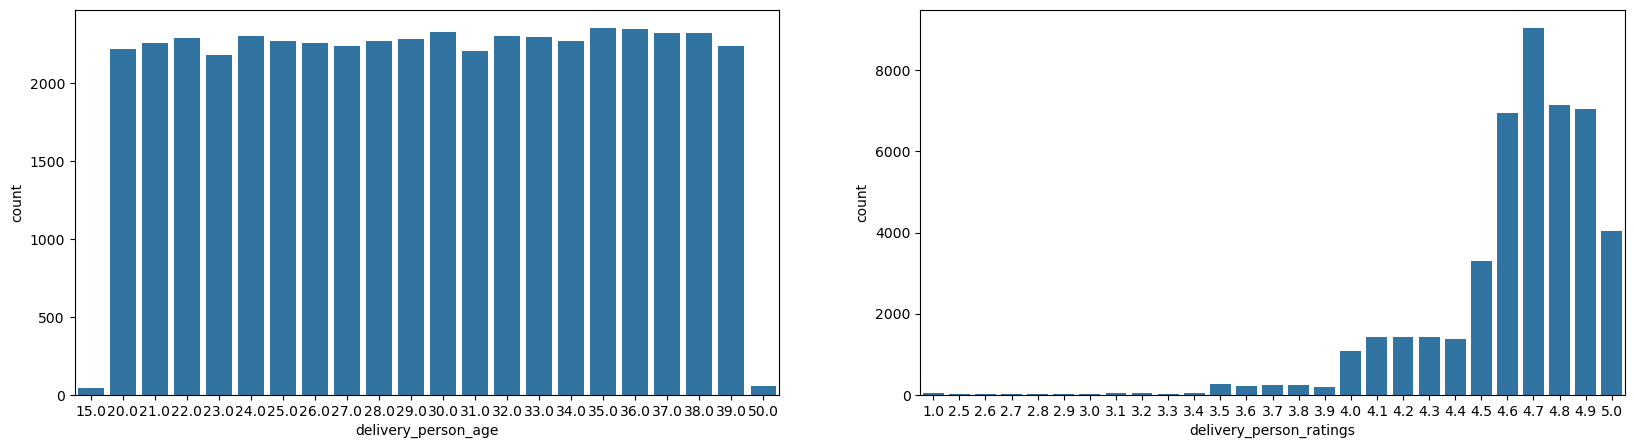

In [15]:
# Create the bins order for the numerical variables
bins1 = df['delivery_person_age'].value_counts().sort_index().index
bins2 = df['delivery_person_ratings'].value_counts().sort_index().index

fig, ax = plt.subplots(1,2,figsize=(20, 5))

sns.countplot(data=df, x='delivery_person_age', order=bins1, ax= ax[0])
sns.countplot(data=df, x='delivery_person_ratings', order=bins2, ax= ax[1])

# Show the plot
plt.show()


#### Handling Missing Values Categorical Columns

In [16]:
col_names = ['city','multiple_deliveries','weather_conditions','road_traffic_density','festival']
## to show the graph: 
bins = []
for i in col_names: 
    bins.append(df[i].value_counts().sort_index().index)

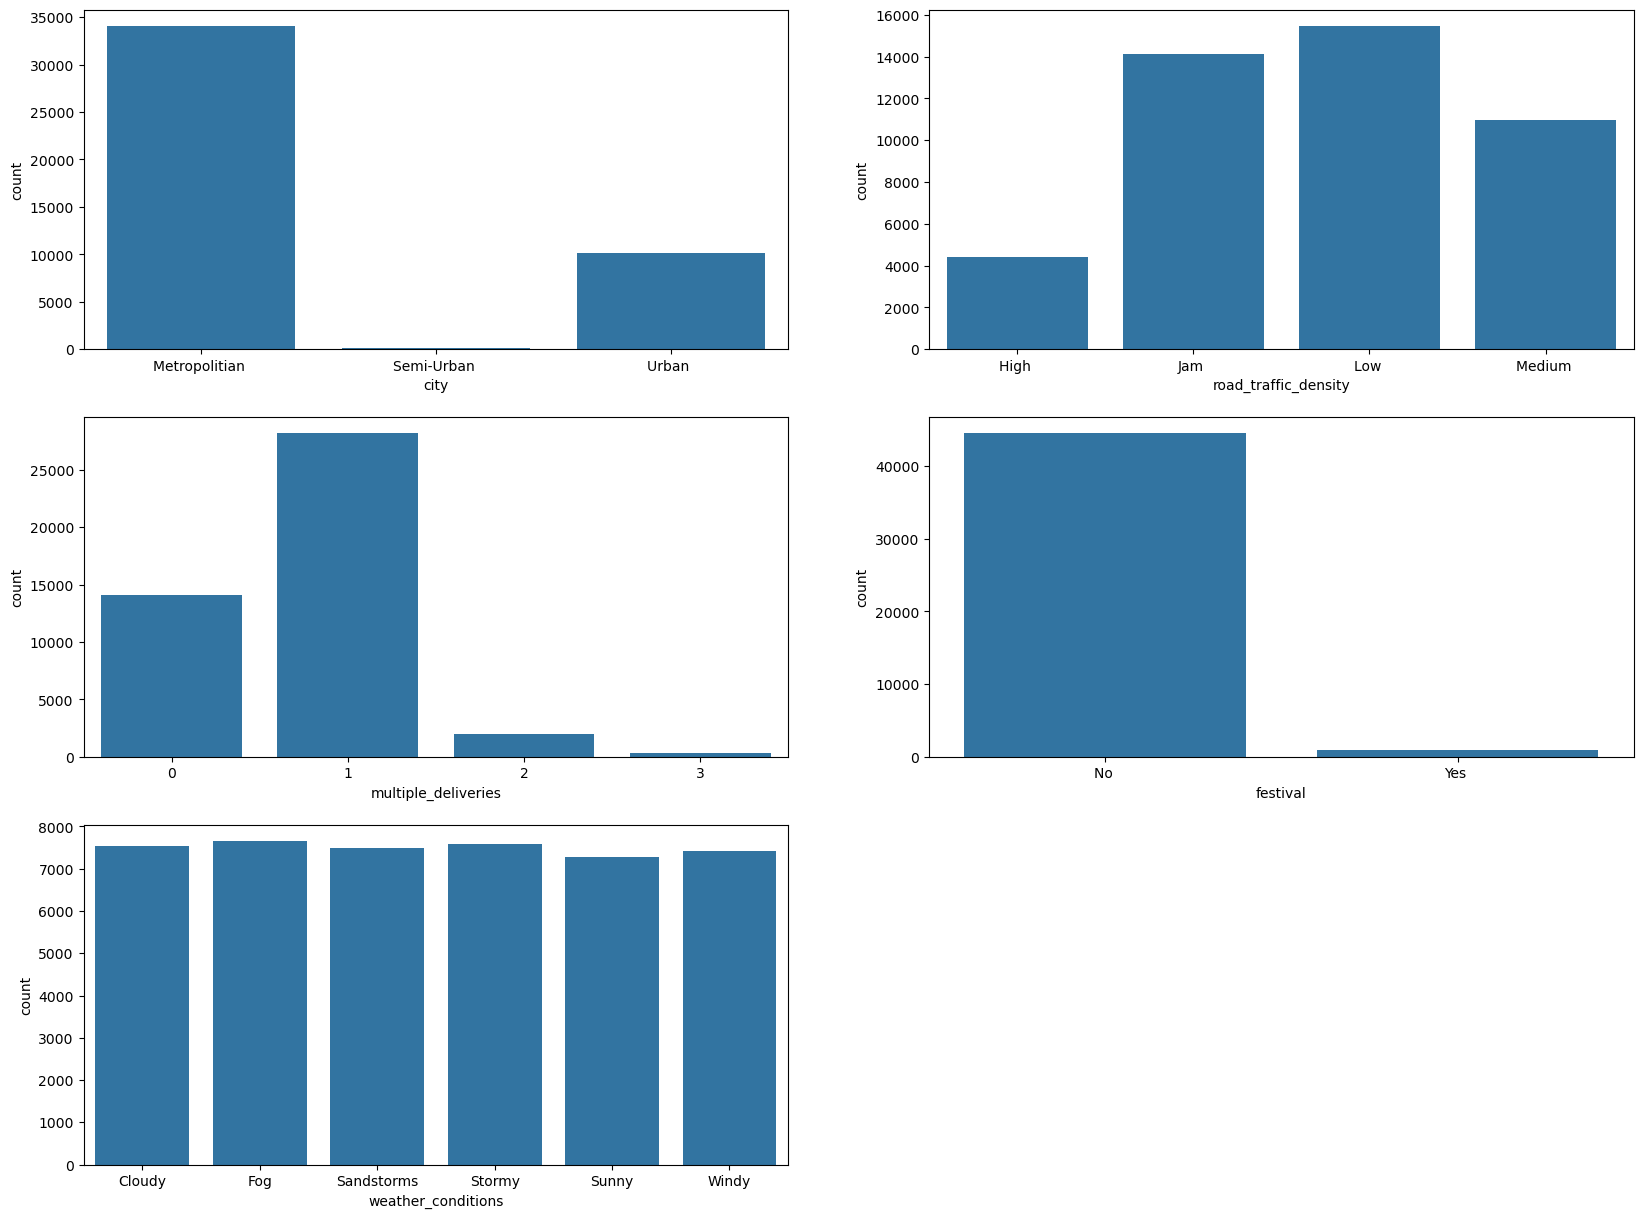

In [17]:
fig, ax = plt.subplots(3,2,figsize=(20, 15))
## for sns countplot 
for i, name in enumerate(col_names): 
    if i == 0: 
        axes = [0,0]
    elif i < 3: 
        axes = [i,0]
    else: 
        axes =[i-3,1]
    sns.countplot(data=df, x = name, order = bins[i], ax = ax[axes[0],axes[1]])
ax[2, 1].axis('off')
plt.show()

For categorical variables, the missing values will be replaced with the mode

In [18]:
# For categorical variables, the empty values will be replaced with the mode
for name in col_names: 
    df[name].fillna(df[name].mode()[0],inplace = True)
    print(name,'null values: ',str(df[name].isnull().sum()))

city null values:  0
multiple_deliveries null values:  0
weather_conditions null values:  0
road_traffic_density null values:  0
festival null values:  0


In [19]:
df.isnull().sum().sort_values(ascending = False)

time_orderd                    1731
id                                0
weather_conditions                0
time_taken_min                    0
city                              0
festival                          0
multiple_deliveries               0
type_of_vehicle                   0
type_of_order                     0
vehicle_condition                 0
road_traffic_density              0
time_order_picked                 0
delivery_person_id                0
order_date                        0
delivery_location_longitude       0
delivery_location_latitude        0
restaurant_longitude              0
restaurant_latitude               0
delivery_person_ratings           0
delivery_person_age               0
delivery_city                     0
dtype: int64

How to handle the time orderd missing values: 
1. We get the median of how long does the merchant prepares an order (duration)
2. Duration = time_order_picked - time_orderd
3. Time_orderd = time_order_picked - duration 

In [20]:
df['duration'] = np.where(pd.isna(df['time_orderd']),pd.NaT,np.where(pd.to_timedelta(df['time_order_picked'])>pd.to_timedelta(df['time_orderd']),
                            (pd.to_timedelta(df['time_order_picked']) - pd.to_timedelta(df['time_orderd'])).dt.total_seconds()/60,
                            (pd.to_timedelta(df['time_order_picked']) - pd.to_timedelta(df['time_orderd'])).dt.total_seconds()/60+1440
                          )
                         )

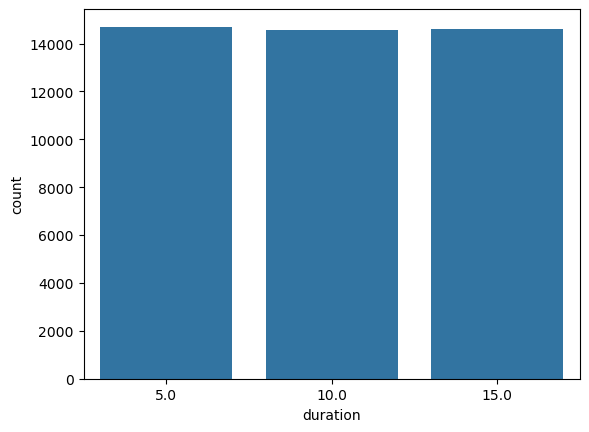

In [21]:
bins = df['duration'].value_counts().sort_index().index
sns.countplot(data = df, x = 'duration',order = bins) 
plt.show()

It seems that there are only three possible duration for the order preparation: 5, 10, and 15 mins. The null values for the time order will be inserted by substracting the order picked up time with any of the duration.

In [24]:
df['duration'] = df['duration'].apply(lambda x: np.random.choice([5,10,15]) if pd.isna(x) else x)

In [25]:
df['time_orderd'] = np.where(pd.isna(df['time_orderd']),
                              pd.to_timedelta(df['time_order_picked']).sub(pd.to_timedelta(df['duration'],unit ='min')),
                              df['time_orderd']
                             )

### Distance

Next we will calculate the distance between the restaurant and the delivery location by using their latitude and longitude

In [26]:
## Order Number on each restaurant location
df.groupby(['restaurant_latitude','restaurant_longitude'])['id'].count().sort_values(ascending = False)

restaurant_latitude  restaurant_longitude
 0.000000             0.000000               3640
 26.911378            75.789034               182
 26.914142            75.805704               180
 26.892312            75.806896               176
 26.902908            75.792934               176
                                             ... 
-21.173343           -72.792731                 1
-21.170798            72.790489                 1
-21.152760           -72.778059                 1
                      72.778059                 1
-30.905562           -75.832841                 1
Name: id, Length: 704, dtype: int64

It seems that many of the orders come from the restaurant located in 0,0 which seems to be an incorrect coordinate so we will drop these rows

In [27]:
df = df.drop(df[(df['restaurant_latitude']== 0) & (df['restaurant_longitude']==0)].index)

In [29]:
## Calculating the distance 
restaurant_loc = df[['restaurant_latitude','restaurant_longitude']].to_numpy()
delivery_loc = df[['delivery_location_latitude','delivery_location_longitude']].to_numpy()

In [30]:
dis = []
for i in range(restaurant_loc.shape[0]): 
    dis.append(geodesic(restaurant_loc[i],delivery_loc[i]).km)

In [31]:
df['distance_km'] = dis

## Time Order Grouping

Since the time order variable is in datetime format, we will convert it to other variables that can be 

In [32]:
df['order_day'] = pd.to_datetime(df['order_date']).dt.day_of_week.astype(int)
df['order_weekend'] = np.where(np.logical_or(df['order_day']==5 ,df['order_day']== 6 ),1,0)
df['order_hour'] = pd.to_datetime(df['time_orderd']).dt.hour

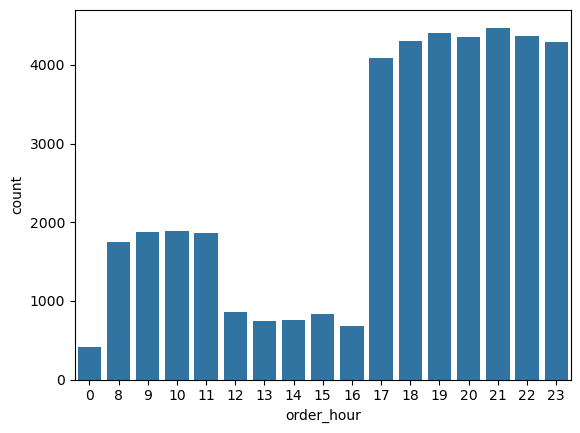

In [33]:
sns.countplot(data = df, x='order_hour',order =(df['order_hour'].value_counts().sort_index().index))
plt.show()

Based on the plot, we could group the time order to 3 groups:  
1. Morning (0 - 11)
2. Afternoon (12-16)
3. Evening (17 - 23)

In [34]:
groups = [0,12,17,24]
cat = ['morning','afternoon','evening']
df['order_hour_cat']= pd.cut(df['order_hour'],bins = groups, labels = cat, right = False)

### Model Building

In [35]:
## Separating the numerical and categorical variables
x1 = ['delivery_person_age','delivery_person_ratings','duration','distance_km'] 
x2 = ['weather_conditions','road_traffic_density','vehicle_condition','type_of_order','type_of_vehicle','multiple_deliveries',
      'festival','city','delivery_city','order_day','order_weekend','order_hour_cat']
y = ['time_taken_min']

In [36]:
## Label encoder for the categorical variables 
for i in x2: 
    if df[i].dtypes == 'object' or df[i].dtypes == 'category':
        df[str(i)+'_encoded'] = LabelEncoder().fit_transform(df[i])
        df[str(i)+'_encoded']  =  df[str(i)+'_encoded']
    else: 
        df[str(i)+'_encoded']  = df[i].astype('category')

In [37]:
x3 = ['weather_conditions_encoded','road_traffic_density_encoded','vehicle_condition_encoded','type_of_order_encoded','type_of_vehicle_encoded','multiple_deliveries_encoded',
      'festival_encoded','city_encoded','delivery_city_encoded','order_day_encoded','order_weekend_encoded','order_hour_cat_encoded']

## Correlation Analysis

<Axes: >

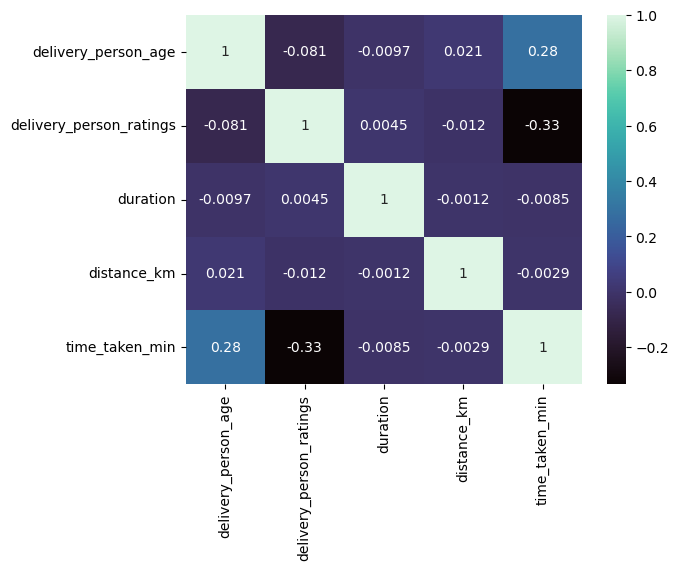

In [38]:
corr = df[x1+y].corr()
sns.heatmap(corr, cmap="mako", annot=True)

Based on the heatmap, there are several things to be deducted: 
1. The delivery person age is the most correlated variable to the target variable (time taken min) even though the correlation is moderate.
2. The delivery person ratings has an inverse correlation with the time taken to deliver the food. The higher the rating of the delivery person, the less time is taken to deliver the food.
3. Surprisingly duration/ preparation duration and distance km also have inverse correlation with the time. 

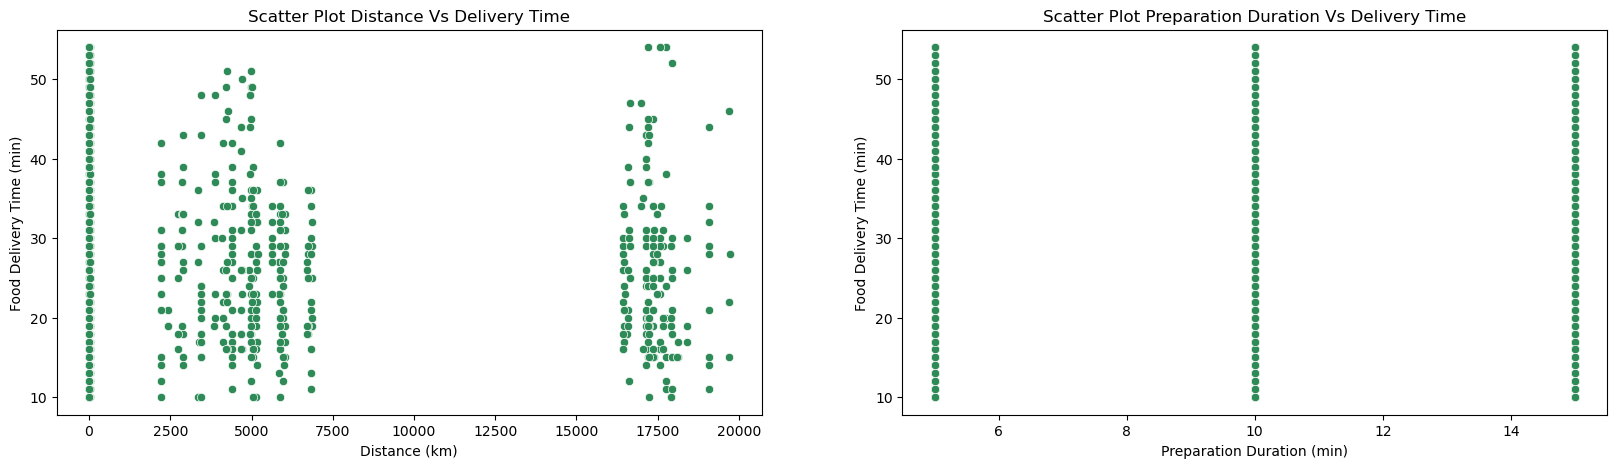

In [39]:
# Scatter plot for the distance, preparation duration against the delivery time
fig, ax = plt.subplots(1,2,figsize=(20, 5))
sns.scatterplot(x=df['distance_km'], y=df['time_taken_min'],ax = ax[0],color = 'seagreen')
sns.scatterplot(x=df['duration'], y=df['time_taken_min'],ax = ax[1],color = 'seagreen')
ax[0].set_title('Scatter Plot Distance Vs Delivery Time')
ax[0].set_xlabel('Distance (km)')
ax[0].set_ylabel('Food Delivery Time (min)')
ax[1].set_title('Scatter Plot Preparation Duration Vs Delivery Time')
ax[1].set_xlabel('Preparation Duration (min)')
ax[1].set_ylabel('Food Delivery Time (min)')
plt.show()

There seems to be a lot of delivery with distance more than 2000km. This could be caused by incorrect coordinates and since this is food delivery, it is very unlikely for the distance to be that far. Thus, we will drop data with distance more than 2000km

In [40]:
df = df.drop(df[df['distance_km']>=2000].index)

In [41]:
df['distance_km'].describe()

count    41522.000000
mean         9.704133
std          5.593935
min          1.463837
25%          4.648474
50%          9.177295
75%         13.659637
max         20.942906
Name: distance_km, dtype: float64

It can be seen that now the distance falls within 1 - 20km

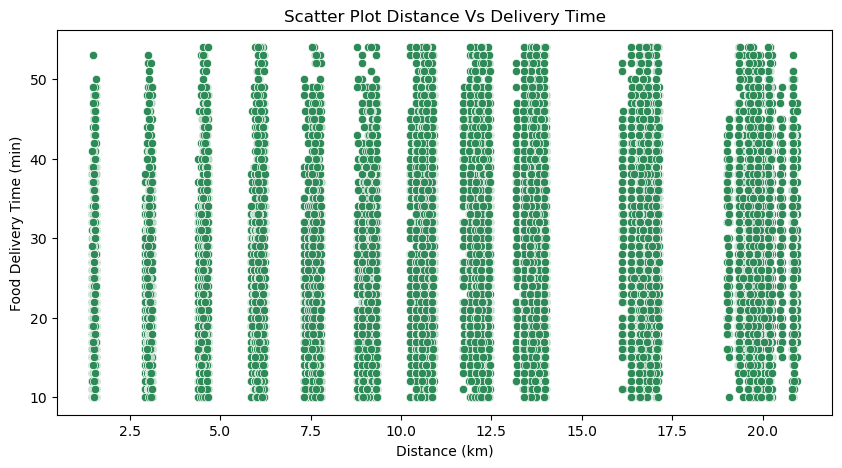

In [42]:
# Scatter plot untuk melihat hubungan antar fitur dengan Delivery_Time_min
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=df['distance_km'], y=df['time_taken_min'],color = 'seagreen')
ax.set_title('Scatter Plot Distance Vs Delivery Time')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Food Delivery Time (min)')

plt.show()

1. The distance distribution seem to be discrete instead of continuous
2. There is no clear linear correlation between distance and the time taken to deliver the food

#### Correlation Analysis between Categorical Variables and Target Variable

In [43]:
from scipy.stats import f_oneway

In [46]:
f_val = []
p_val = []
for i in x2: 
    g = [group['time_taken_min'].values for name, group in df.groupby(i)]
    f_val.append(f_oneway(*g)[0])
    p_val.append(f_oneway(*g)[1])
anova_table = pd.DataFrame({
    'variables': df[x2].columns,
    'f_val': f_val,
    'p-value': p_val,
   'result': ['sig' if p < 0.05 else 'non sig' for p in p_val]
})

In [47]:
anova_table

,variables,f_val,p-value,result
0,weather_conditions,551.695212,0.000000e+00,sig
1,road_traffic_density,3049.182301,0.000000e+00,sig
2,vehicle_condition,1206.123508,0.000000e+00,sig
3,type_of_order,2.019372,1.088342e-01,non sig
4,type_of_vehicle,379.199861,5.266836e-243,sig
5,multiple_deliveries,3103.654351,0.000000e+00,sig
6,festival,3763.292653,0.000000e+00,sig
7,city,1213.333292,0.000000e+00,sig
8,delivery_city,1.566013,4.755606e-02,sig
9,order_day,50.402994,4.230880e-62,sig


Based on the p-values from the ANOVA tests, we observe that the differences in delivery time across the categories of each categorical variable are statistically significant, except for order_weekend and type_of_order.
This indicates that the categorical variables have a significant effect on delivery time and should be considered as important factors in modeling or analyzing food delivery duration.

In [49]:
## Dropping the type of order and order weekend variables from our model
x1 = ['delivery_person_age','delivery_person_ratings','duration','distance_km'] 
y = ['time_taken_min']
x3 = ['weather_conditions_encoded','road_traffic_density_encoded','vehicle_condition_encoded','type_of_vehicle_encoded','multiple_deliveries_encoded',
      'festival_encoded','city_encoded','delivery_city_encoded','order_day_encoded','order_hour_cat_encoded']

### Model Building

In [52]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import xgboost as xgb

In [53]:
x_train, x_test, y_train, y_test = train_test_split(df[x1+x3], df[y], test_size=0.3, random_state=42)

In [54]:
mod = xgb.XGBRegressor()
parameters = {
            'n_estimators':[20,30,40,50], 
            'max_depth': [4,5,6,7,8,9], 
            'enable_categorical':[True]
                }
grid_search = GridSearchCV (mod,parameters, cv = 5, scoring = 'r2')
grid_search.fit(x_train,y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'enable_categorical': [True],
                         'max_depth': [4, 5, 6, 7, 8, 9],
                         'n_estimators': [20, 30, 40, 50]},
             scoring='r2')

In [55]:
print("Parameters with highest r2", grid_search.best_params_)
print("Highest r2 score", grid_search.best_score_)

Parameters with highest r2 {'enable_categorical': True, 'max_depth': 7, 'n_estimators': 20}
Highest r2 score 0.8196536421775817


In [56]:
mod1 = xgb.XGBRegressor(n_estimators = 20, max_depth=8, enable_categorical = True) 
mod1.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=20,
             n_jobs=None, num_parallel_tree=None, ...)

In [57]:
y_pred = mod1.predict(x_test) 
r2 = r2_score(y_test, y_pred)
root_mse = np.sqrt(mean_squared_error(y_test,y_pred))
print("XGBoost Regressor Model Performance")
print("n_estimators: ",mod1.n_estimators)
print("max_depth: ",mod1.max_depth)
print("R2 score: ",r2)
print("Root mean squared error: ",root_mse)

XGBoost Regressor Model Performance
n_estimators:  20
max_depth:  8
R2 score:  0.8251843452453613
Root mean squared error:  3.9274181123441503


The best XGBoost re